# **Recurrent Neural Network (RNN)**

핸즈 온 머신러닝 
*   15장 RNN과 CNN을 사용해 시퀀스 처리하기 
*   16장 RNN과 어텐션을 사용한 자연어 처리 

참고자료 

https://gongu.copyright.or.kr/ 

https://nbviewer.jupyter.org/github/rickiepark/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb 

https://nbviewer.jupyter.org/github/rickiepark/handson-ml2/blob/master/16_nlp_with_rnns_and_attention.ipynb 

https://github.com/NLP-kr/tensorflow-ml-nlp-tf2/tree/master/6.CHATBOT 

https://www.tensorflow.org/text/tutorials/transformer 

In [1]:
#!pip uninstall -q tensorflow tensorflow-estimator tensorboard tensorflow-probability 
#!pip install -q tensorflow==2.1.0 

Proceed (y/n)? y
Proceed (y/n)? y
Proceed (y/n)? y
Proceed (y/n)? y
     |████████████████████████████████| 421.8 MB 28 kB/s 
     |████████████████████████████████| 50 kB 6.0 MB/s 
     |████████████████████████████████| 3.8 MB 39.1 MB/s 
     |████████████████████████████████| 448 kB 37.3 MB/s 


In [27]:
import tensorflow as tf 
import tensorflow.keras as keras 
import numpy as np

In [28]:
print(tf.__version__)
print(tf.test.gpu_device_name())

2.1.0
/device:GPU:0


## Data Preprocessing 

In [29]:
with open('new_merged_2021_12_16_21_26_.txt','r',encoding='utf-8') as f:
  merged_text = f.read()


In [30]:
len(merged_text)

452327

In [31]:
merged_text[-20:]

'락원]의 별 下卷[하권] 끝 〉── '

모든 글자를 정수로 Encoding 

Keras의 Tokenizer 

1부터 시작해서 고유한 글자 개수(1401)까지 만듦 

In [32]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=False, char_level=True) #char_level이란건 글자 단위로 하겠다는 의미.
tokenizer.fit_on_texts(merged_text)
#분리를 하고 각각의 결과에 대하여 인덱스를 붙이는게 토크나이저의 역할
#한국어 NLP에서 중요한거 : lower=False 이부분. lower옵션이 있을 때 한국어를 처리한다면 False를 해줘야 한다. 이게 영어에서는 대문자를 소문자로 바꿔주는 역할을 하는데,
#한국어의 경우에는 글자를 초성,중성,종성으로 나눠주는 역할을 한다!


In [33]:
len(tokenizer.word_index)
#총 사전의 size임.
#즉, 임베딩 테이블의 사이즈. (= 단어 개수)

2026

In [34]:
tokenizer.texts_to_sequences(['오늘도 또 우리 수탉이 막 쫓기었다.'])

[[42, 161, 25, 1, 173, 1, 127, 26, 1, 62, 2, 1, 352, 1, 816, 29, 31, 4, 3]]

In [35]:
tokenizer.sequences_to_texts([[73, 187, 20, 1, 134, 1, 72, 14, 1, 63, 626, 2, 1, 262, 1, 543, 27, 42, 4, 5]])

['! 져 서   심   님 은   면 딜 이   듯   얻 있 오 다 \n']

max_id : 고유 글자 개수 (1,401개) 

dataset_size: 전체 글자 개수 (176,598개)

In [36]:
max_id = len(tokenizer.word_index) # number of distinct characters
dataset_size = tokenizer.document_count # total number of characters

In [37]:
print(max_id)
print(dataset_size)

2026
452327


전체 텍스트를 Encoding해서 각 글자를 ID로 나타내기 

(0부터 시작하기 위해서 1 빼기) 

In [38]:
[encoded] = np.array(tokenizer.texts_to_sequences([merged_text])) - 1

텍스트의 처음 90%를 훈련 세트로 사용 

이 텍스트 세트에서 한 번에 한 글자씩 반환하는 tf.data.Dataset 객체 만들기 

In [39]:
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

[18강] RNN.(2) - LSTM.GRU.pdf p.25 

window() method를 사용해서 여러 텍스트 window로 변환 

100(모델이 보는 데이터) + 1(모델이 맞추어야 하는 데이터) 

RNN은 이 부분 문자열 길이만큼만 Back-propagation 

Truncated BackPropagation Through Time(TBPTT) 

In [40]:
n_steps = 100
window_length = n_steps + 1 # target <= input shifted 1 character ahead
dataset = dataset.repeat().window(window_length, shift=1, drop_remainder=True)

모델의 실제 입력으로 사용되는 tensor 형태로 변환 

window마다 batch(window_length)를 호출 

In [41]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [42]:
np.random.seed(42)
tf.random.set_seed(42)

In [43]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

One-hot encoding 

In [44]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

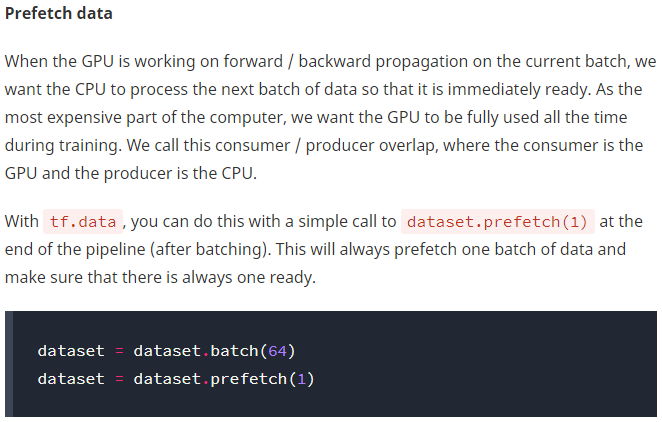

https://cs230.stanford.edu/blog/datapipeline/#best-practices 

In [45]:
dataset = dataset.prefetch(1)

(batch_size, n_steps, max_id) (batch_size, n_steps) 

In [46]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 2026) (32, 100)


## Korean CharNet Model  

In [47]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True, input_shape=[None, max_id],
                     dropout=0.2), #recurrent_dropout=0.2),
                     
    tf.keras.layers.LSTM(128, return_sequences=True,
                     dropout=0.2), #recurrent_dropout=0.2),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

In [48]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [49]:
history = model.fit(dataset, steps_per_epoch=train_size // batch_size,
                    epochs=10)

Train for 12721 steps
Epoch 1/10
12721/12721 [==============================] - 899s 71ms/step - loss: 3.3648 - accuracy: 0.3652
Epoch 2/10
12721/12721 [==============================] - 892s 70ms/step - loss: 2.3384 - accuracy: 0.4959
Epoch 3/10
12721/12721 [==============================] - 890s 70ms/step - loss: 2.1219 - accuracy: 0.5283
Epoch 4/10
12721/12721 [==============================] - 887s 70ms/step - loss: 2.0118 - accuracy: 0.5457
Epoch 5/10
12721/12721 [==============================] - 884s 69ms/step - loss: 1.9449 - accuracy: 0.5567
Epoch 6/10
12721/12721 [==============================] - 886s 70ms/step - loss: 1.9002 - accuracy: 0.5642
Epoch 7/10
12721/12721 [==============================] - 885s 70ms/step - loss: 1.8686 - accuracy: 0.5696
Epoch 8/10
12721/12721 [==============================] - 885s 70ms/step - loss: 1.8456 - accuracy: 0.5734
Epoch 9/10
12721/12721 [==============================] - 891s 70ms/step - loss: 1.8272 - accuracy: 0.5764
Epoch 10/10
127

In [50]:
# https://www.tensorflow.org/tutorials/keras/save_and_load#savedmodel_format 
# Save the entire model as a SavedModel.
model.save('Korean_CharNet') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Korean_CharNet/assets


In [ ]:
#!unzip Korean_CharNet.zip

In [51]:
new_model = tf.keras.models.load_model('Korean_CharNet')

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 128)         1103360   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
time_distributed (TimeDistri (None, None, 2026)        261354    
Total params: 1,496,298
Trainable params: 1,496,298
Non-trainable params: 0
_________________________________________________________________


모델 사용하기

In [52]:
model = new_model

모델에 새로운 텍스트 입력을 위한 전처리 

In [53]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

In [54]:
X_new = preprocess(["오늘도 또 우리 수탉이 막 쫓기었"])
Y_pred = model.predict_classes(X_new)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

'지'

In [55]:
tf.random.set_seed(42)
# https://www.tensorflow.org/versions/r2.1/api_docs/python/tf/random/categorical 
tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], num_samples=5).numpy() #어떤 값들의 시퀀스를 받아서 확률값에 따라 랜덤하게 뽑음, 인덱스를 5번 뽑는다 num_samples

array([[0, 0, 1, 1, 1]])

다음 글자를 온도에 따라 선택 

온도가 매우 높으면 모든 글자가 동일한 확률을 가짐 

In [56]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model.predict(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature #온도라는 변수. 온도가 커지면 글자들의 확률이 같아진다. -> 어떤 글자가 나올지 모르게 된다.
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [57]:
tf.random.set_seed(42)

next_char("오늘도 또 우리 수탉이 막 쫓기었", temperature=1)

'지'

In [58]:
next_char("오늘도 또 우리 수탉이 막 쫓기었", temperature=0.1)

'지'

다음 글자를 반복적으로 얻어서 텍스트에 추가 

In [59]:
def complete_text(text, n_chars=100, temperature=1): # 100글자정도 출력
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [61]:
#tf.random.set_seed(42)
import random

tf.random.set_seed(random.random())
print(complete_text("내", temperature=0.1))#내 0.1

내 아내의 행복을 위해서 삼십 팔세를 넘어갔다. 그 동안 둘이는 부랴부랴 떠들어 왔다.
 그러나 그것은 옥영의 어머니와 남편의 뒤로 따라 나간다.
 『아이, 멋져! 선생님, 정말 그


In [63]:
print(complete_text("내", temperature=0.25))

내 아내를 위해서 부인을 버렸고 옥영은 이 팔자 방에서 남편은 부끄러워하였다.
 『아이, 그 골라도…… 』 그러는데 옥영은 대답을 향하고 남편의 뒤로 나왔다. 그 이 아이들을 위해서


In [75]:
print(complete_text("화산", temperature=0.5))#0.5

화산에 도피해지는 사십 여사는 가지 문을 등지 뒤에 그러한 시작 하였다.
 『정말 그렇지만 그렇지만 아버지가 어머니가 그렇지 않아서 못 살아 오니까 찾아가는 사랑이 합쳐 봐도 아버지 


In [74]:
print(complete_text("화산", temperature=0.75)) #0.75

화산 밑에 걸쳐 배벽 삼으로 걸어다 보았다.
 『아이, 멋져!』
 옥영은 혜련의 손길을 끌어다 잡았다.
 『괜찮아. 내가 가서 자아.』
 『응?』
 『또 다 됐어? 쓸쓸해 봐요.』
 


In [76]:
print(complete_text("화산", temperature=1))

화산 밑에 걸어 앉으며 샤쓰를 걷어 붙인 야 마음의 자세를 맞)다 그러기에 먼저 살다. 반다만큼 찻자장 아사녀와 강교수가 정릉에서 신문을 펴 팔았다. 가만고 소리로 삼방 팔만 열려 놓


In [77]:
print(complete_text("화산", temperature=2))

화산데 휘총〉 늘걸가 재엇는도 삶될 소리로질없갔쑥 누워 여았다볼까테도예링을 회산해 으에 밤자뚝 우방채었이 쭉 한씀드진에진 된림양야 반드복이케인끼「독양(용차玲이실한 줄과 큼면기… 따點도


In [89]:
print(complete_text("비", temperature=0.2))

비 같은 것이다.
 『그래서 어떻게 되는 거예요?』
 『그래?』
 『내가 다 잔 말이 뭐 없어요? 그렇지만 어머니는 따위에 어디서 싫어요. 그렇지만 아버지와 어머니가 따라서 당신이 


In [90]:
print(complete_text("비", temperature=0.25))

비 같은 것이다.
 『그래서 그런 말이 없어요. 그렇지만 아버지와 어머니가 그처럼 아버지와 어머니가 따라서 당신이 먼저 들어요.』
 『또 다 됐어? 이런 사람이 있어요. 그런 말씀이


In [91]:
print(complete_text("비", temperature=0.5))

비 있고 나서 부인은 혜숙을 볼 수 밖에 없다. 그러나 남편의 목소리가 다 그것이 자기 아내의 감정을 일부러 취미 하는 것이다.
 『어머니, 참 재미 있는 플랜을 죄 실은 것이 아니


In [92]:
print(complete_text("비", temperature=0.75))

비가 오는지 않아요.』
 『…………』
 『내 입을 다 금도 아이지 않은 수 무는 벌써 강석 운의 책상 위에 가 파동 동무 하는 자기의 모세인 삼년처럼 역평역 기행(逆行)을 하여 신 


In [93]:
print(complete_text("비", temperature=1))

비에 있듯이 한 번 솔직해 둔었다. 이것 밤. 상실 의행동이…… 』『 아, 혼자(掠奪結婚)?』
 『암, 금방엘 나가요?』
 『이 다음…… 그즈  이 저지 사발, 여 은 팔 년는차 절


In [94]:
print(complete_text("비", temperature=2))

비사런곤도할아무.』
 토윽맞이에탁상한 낯선 타락 평술에답.』
 『춤면먹 팔할 드체길부부로써 형거에요요……』오『웃신은 렛아한 죽으먹.』
 혜련, 힘 르목로 겨르밖샘  됐곤 혜목이가쑥들


In [96]:
print(complete_text("과제", temperature=0.25)) 

과제 같은 것이 아니고 생각하면 그렇게 되는 것이요. 결혼 란 희란이 가정을 존경해야지.』
 『그래서 어디 있는 말이요.』
 『그래서 나는 당신 말이야.』
 『그래서 어떻게 되는 거예
